In [1]:
#pip install transformers torch sentencepiece

In [1]:
import json
import matplotlib.pyplot as plt
from transformers import T5ForConditionalGeneration, T5Tokenizer
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
nltk.download('wordnet');
nltk.download('stopwords');

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\maudt\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\maudt\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


## Load reviews

In [2]:
file_path = 'reviews_TripAdvisor.json'
with open(file_path, 'r') as file:
    reviews = json.load(file)

In [3]:
all_reviews =[]
for id_,dicoReview in reviews.items():
    all_reviews.append([title.lower()+" "+critique.lower() if critique is not None else "None" for title,critique in dicoReview.items()])
all_reviews = [" ".join(item) for item in all_reviews]
all_ids     = list(reviews.keys())

In [4]:
print("number of ids     : ",len(all_ids))
print("number of reviews : ",len(all_reviews))

number of ids     :  220
number of reviews :  220


## Pre-Processing

#### Definitions

In [8]:
def processReview(r,del_=None):
    lemmatiseur = WordNetLemmatizer()
    stop_words_en = set(stopwords.words('english'))
    stop_words_fr = set(stopwords.words('french'))
    stop_words    = stop_words_en | stop_words_fr
    
    ponctuation = [".",",",":","'","!","-","?","(",")"]
    for p in ponctuation :
        r = r.replace(p," ")
    
    r=r.replace(".", "").replace(",", "").replace(":"," ").replace("'"," ").replace("!"," ").replace("-"," ").replace("?"," ")
    mots = r.split()
    
    mots = [mot for mot in mots if mot not in stop_words]
    mots = [lemmatiseur.lemmatize(mot) for mot in mots]
    if del_ is not None:
        mots = [mot for mot in mots if mot not in del_]
    return " ".join(mots)

def compter_occurrence_mots(texte):
    mots = texte.split(" ")
    occurrence_mots = {}
    for mot in mots:
        occurrence_mots[mot] = occurrence_mots.get(mot, 0) + 1
    return occurrence_mots

#### Analyse of unique words

8553 uniques words before processing
4701 uniques words after processing


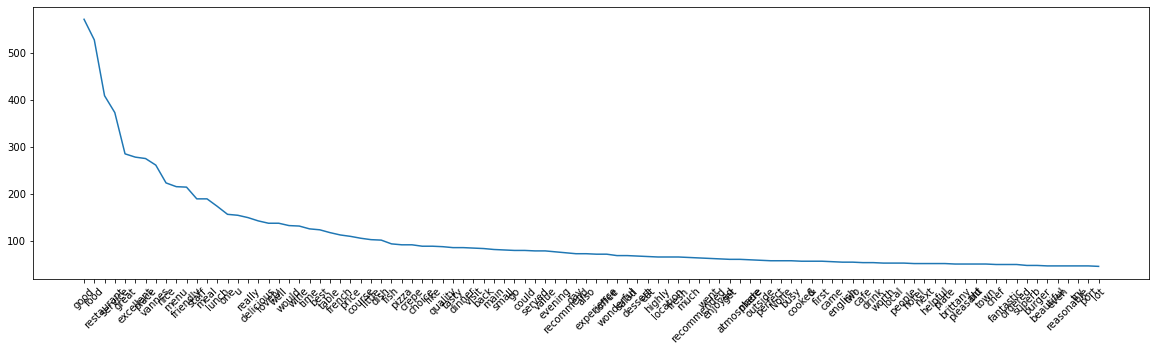

In [10]:
analyse = " ".join(all_reviews)
print(f"{len(compter_occurrence_mots(analyse))} uniques words before processing")

analyse = processReview(analyse)
occurences_dic = compter_occurrence_mots(analyse)
print(f"{len(occurences_dic)} uniques words after processing")

occurences_dic = compter_occurrence_mots(analyse)
occurences_dic = dict(sorted(list(occurences_dic.items()), key=lambda x: x[1], reverse=True))



mots_uniques = list(occurences_dic.keys())[0:100]
occur = list(occurences_dic.values())[0:100]
fig = plt.figure(figsize=(20,5))
plt.plot(occur)
plt.xticks(range(len(mots_uniques)), mots_uniques, rotation=45)
plt.show()

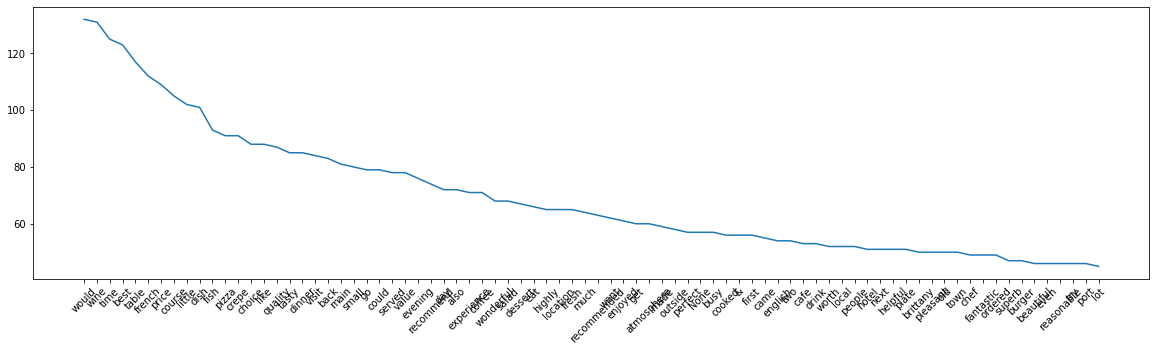

In [11]:
most_freq = mots_uniques[0:20]

mots_uniques = list(occurences_dic.keys())[20:100]
occur = list(occurences_dic.values())[20:100]
fig = plt.figure(figsize=(20,5))
plt.plot(occur)
plt.xticks(range(len(mots_uniques)), mots_uniques, rotation=45)
plt.show()

## Summarization

#### Load t5

In [43]:
model = T5ForConditionalGeneration.from_pretrained("t5-base")
tokenizer = T5Tokenizer.from_pretrained("t5-base")

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


#### Summarize

In [45]:
reviews_sum = {}
for i in range(len(all_reviews)):
    text = processReview(all_reviews[i],del_=most_freq)
    id_  = all_ids[i]
    if len(text.split(" "))>1:
        inputs = tokenizer.encode("summarize: " + text, 
                                  return_tensors = "pt", 
                                  max_length     = len(text.split(" ")), 
                                  truncation     = True)
        outputs = model.generate(inputs, 
                                 max_length     = int(len(text.split(" "))//3),
                                 min_length     = int(len(text.split(" "))**(1/2)),
                                 length_penalty = 2.0, 
                                 num_beams      = 4, 
                                 early_stopping = True)
        reviews_sum[str(id_)] = tokenizer.decode(outputs[0])

#### process results

In [55]:
summaries = {}
for k,v in reviews_sum.items():
    if v[-1]=='>':
        summaries[k] = v[5:-4] 
    else:
        summaries[k] = v[5:]

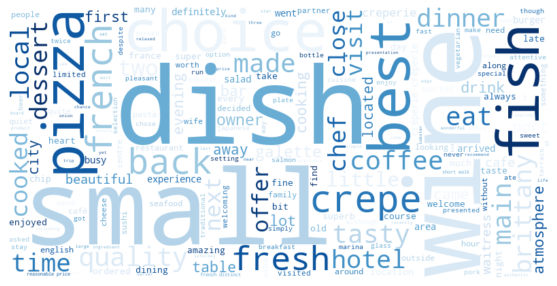

In [65]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

text = ' '.join(list(summaries.values()))
wordcloud = WordCloud(background_color='white',width=800,height=400,colormap='Blues',max_words=200)
wordcloud.generate(text)
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

In [50]:
with open("summaries.json", "w") as json_file:
    json.dump(summaries, json_file)